<img src="https://www.rochester.edu/assets/images/ur-logo.svg">

# <center>[CSC 249/449: Machine Vision](https://www.cs.rochester.edu/~cxu22/t/249S22/)</center>


1. Make sure you fill in all cells contain `YOUR CODE HERE` or `YOUR ANSWER HERE`.
2. After you finished, `Restart the kernel & run` all cell in order.
---------


# Image Stitching


Image 1 | Image 2
- | - 
<img src="./left.png" height="350" />| <img src="./right.png" height="350"/>


The goal of this problem set is to stitch the above two images together, which summarizes what we have learned so far.

Thinking about taking panoramas photos with your phone, it's essentially combining multiple images with the overlapped field in real-time.
To achieve this goal, the general pipeline involves the following steps:

1. **Feature Detection**: Identify interest points in the image with the Harris corner detector.
2. **Feature Description**: Extract the feature centered at each interest point. 
3. **Feature Matching**: Each image will have a set of interest points and the corresponding feature. For a given feature in one image, we'd like to find the best match feature in the other image.
4. **Fitting**: Now you have pairs of interesting points. Just like the camera model, we can estimate the transformation of two images.
5. **Alignment**: Once we know the transformation, we'll transform one image to the same coordinates system as the other one and stitch them together

> Note: Since all hyperparameters highly depend on your implementation, there is no standard value. The checkpoint before fitting will help you find good values for the first half. For the second half, you can rely on the qualitative result of the final image.


In [9]:
import csc249
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
img1 = cv2.cvtColor(cv2.imread(str(csc249.data/'left.png')), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(str(csc249.data/'right.png')), cv2.COLOR_BGR2RGB)

## Feature detection 

Detecting interest point is to find image regions that are usually in terms of pixel value change.
Here, we use corner detection to spot the interest points.
Specifically, we are going to implement the Harris Detector, which contains the following steps:

### 1. Compute Harris corner strength

For each point in the image, consider a window of pixels around that point.
Compute the Harris matrix H for (the window around) that point, defined as

$$
H=w \circledast \left[\begin{array}{cc}
I^{2}_x & I_xI_y  \\
I_xI_y & I^{2}_y
\end{array}\right]\\
$$
where $w \circledast$ means applying the gaussian filter. Then we can compute the corner strength as

$$
c(H)=\frac{\det(H)}{\operatorname{trace}(H)}\\
$$
> hint: when doing divide, it's always a good idea to add a small value (1e-7) to the denominator to avoid dividing by zero.
### 2. Non maximum suppression

In this step, we want to find local maxima in the window. Just like filtering, for every pixel, we replace it with the maxima in the `3x3` window surrounding it. This step will help us select the most representative pixel inside the region and prevent the situation where too many interest points are crowded inside a small region. 

### 3. Thresholding

After the suppression, we will pick up the pixel locations that are:
1. local maxima
2. greater than `threshold * global maxima`

The return of this function is list of keypoints with `cv2.KeyPoint()` datatype, you can use find `cv2.KeyPoint(float(x), float(y), 1)` to construst 1 keypoint or find [more detils here](https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_feature_detectors.html). 



In [10]:
def gaussian_kernel(shape=(5,5),sigma=5):
    """
    Arguments:
    ----------
        shape : tuple
            size of the filter.
            A 3D numpy.ndarray of shape (h,w).
        sigma : real number
            shapeness of the filter.
    Returns:
    --------
        Gaussian filter with specified shape.
    """
    gaussian_filter = np.zeros(shape)
    s = 2*sigma*sigma
    a = np.linspace(-(shape[0]-1)//2,(shape[0]-1)//2,num=shape[0])
    b = np.linspace(-(shape[1]-1)//2,(shape[1]-1)//2,num=shape[1])
    for x in range(shape[0]):
        for y in range(shape[1]):
            r = np.sqrt(a[x]*a[x]+b[y]*b[y])
            gaussian_filter[x][y] = np.exp(r*r/(-s))/(s*np.pi)
    
    return gaussian_filter

In [11]:
def firstorder():
    """
    Returns:
    --------
        filter X: numpy.ndarray
        filter Y: numpy.ndarray  
    """
    X = np.array([-1,1]).reshape(1,2)
    Y = np.array([-1,1]).reshape(2,1)
    
    return {'filterX': X,
            'filterY':Y}

In [12]:
def feature_detection(grey,threshold=0.5):
    # 
    #compute corner strenth
    rows,cols = grey.shape
    filters = firstorder()
#     grey = cv2.filter2D(grey,ddepth=-1,kernel=gaussian_kernel((5,5),5))
    I_x = cv2.filter2D(grey,ddepth=-1,kernel=filters['filterX'])
    I_y = cv2.filter2D(grey,ddepth=-1,kernel=filters['filterY'])
    
    gau_Ix2 = cv2.filter2D(I_x * I_x,ddepth=-1,kernel=gaussian_kernel((5,5),5))
    gau_Iy2 = cv2.filter2D(I_y * I_y,ddepth=-1,kernel=gaussian_kernel((5,5),5))
    gau_Ixy = cv2.filter2D(I_x * I_y,ddepth=-1,kernel=gaussian_kernel((5,5),5))
    
    
    c_H = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
#             temp_H = np.array([I_x[i,j]*I_x[i,j],I_x[i,j]*I_y[i,j],I_x[i,j]*I_y[i,j],I_y[i,j]*I_y[i,j]]).reshape((2,2))
            temp_H = np.array([gau_Ix2[i,j],gau_Ixy[i,j],gau_Ixy[i,j],gau_Iy2[i,j]]).reshape((2,2))
            evalue = np.linalg.eig(temp_H)[0]
            c_H[i,j] = evalue[0]*evalue[1]/(evalue[0]+evalue[1]+1e-7)
#             det = gau_Ix2[i,j]*gau_Iy2[i,j]-gau_Ixy[i,j]*gau_Ixy[i,j]
#             trace = gau_Ix2[i,j] + gau_Iy2[i,j] + 1e-7
#             c_H[i,j] = det / trace
    
    #Non maximum suppression
    ws = 3
    after_sup = np.zeros((rows,cols))
    for i in range(ws//2,rows-ws//2):
        for j in range(ws//2,cols-ws//2):
            after_sup[i,j] = np.max(c_H[i-ws//2:i+ws//2+1 , j-ws//2:j+ws//2+1])
    
    #Thresholding
    keypoints = []
    thresh_value = np.max(c_H)*threshold
    for i in range(rows):
        for j in range(cols):
            if c_H[i,j] == after_sup[i,j] and c_H[i,j] > thresh_value:
                keypoints.append(cv2.KeyPoint(float(j), float(i), 1))
    return keypoints
    

## Feature description

Since we've implemented HOG last time, we'll use build-in functions to obtain the feature description this time.

In [13]:
kp1= feature_detection(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY))
kp2= feature_detection(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))
sift = cv2.SIFT_create()
k1, d1 = sift.compute(img1,kp1)
k2, d2 = sift.compute(img2,kp2)

## Feature matching

Recall from the last problem set, once we have the description for each interest point, we can compute the distance between them. The Brute-Force matcher will match the one given feature with all other features in the second set with the smallest distance.
However, this will introduce ambiguous matches, here we implement a more robust matcher which contains two parts:
1. `knn(query, value,k)`: the `query` and `value` are two sets of distances (`d1`and`d2` above), for every element in the `query` set, you'll need to find `k` nearest neighbor in the `value` set. The return of this function is **list of list of `cv2.DMatch` datatype** which you can construct with `cv2.DMatch(idx_in_query,neighbor_idx_in_value,0,distance)` and you can find [more info here](https://docs.opencv.org/2.4/modules/features2d/doc/common_interfaces_of_descriptor_matchers.html?highlight=dmatch). Since this function will go through all pairs of `query` and `value`, the running time might be high.
2. `select_match(matches)`: this function will prevent ambiguous matches by selecting the match whose `dist to best match < ratio * dist to second best`(recall from the slides)

The final return is a **list of `cv2.DMatch` datatype** and we'll use it to plot our key points.

In [14]:
def knn(query,value,k=2):
    # return [[match(query_0,nearest_neigh_1),...,match(query_0,nearest_neigh_k)],...,[match(query_-1,nearest_neigh_1),...,match(query_0,nearest_neigh_k)]]
    # 
    ans = []
    #version 1
    for i in range(query.shape[0]):
        dis_iToj = []
        for j in range(value.shape[0]):
            dis_iToj.append(np.linalg.norm(query[i]-value[j],ord=2,axis=0))
        temp = []
        for cur in range(k):
            distance = min(dis_iToj)
            ind = dis_iToj.index(distance)
            dis_iToj[ind] = 1000000
            temp.append(cv2.DMatch(i,ind,0,distance))
        ans.append(temp)

    #version 2
#     distance = query.dot(value.T)
#     for i in range(query.shape[0]):
#         distance = []
#         for j in range(value.shape[0]):
#             distance.append(np.linalg.norm(query[i]-value[j],ord=2,axis=0))
#         temp = []
#         for cur in range(k):
#             dis = min(distance)
#             ind = distance.index(dis)
#             distance[ind] = 1000000
#             temp.append(cv2.DMatch(i,ind,0,dis)) 
#         ans.append(temp)
    
    return ans


In [15]:
def select_match(matches, ratio=0.7):
    # return is list of cv2.DMatch
    # 
    ans = []
    for match in matches:
        if match[0].distance < ratio * match[1].distance:
            ans.append(match[0])
    return ans
good_matches = select_match(knn(d1,d2,k=2), ratio=0.7)
good_matches = good_matches[100:200]


### Display the matches

Now is a good checkpoint for you to check the correctness of the implementation above.
The overlap part should have lines connected together, meaning you find good matches across two images. 
It's normal that you have many interest points on the tree and connect to nowhere because the corner detector finds many "corners" there but the matching algorithm refuses to match these descriptors.

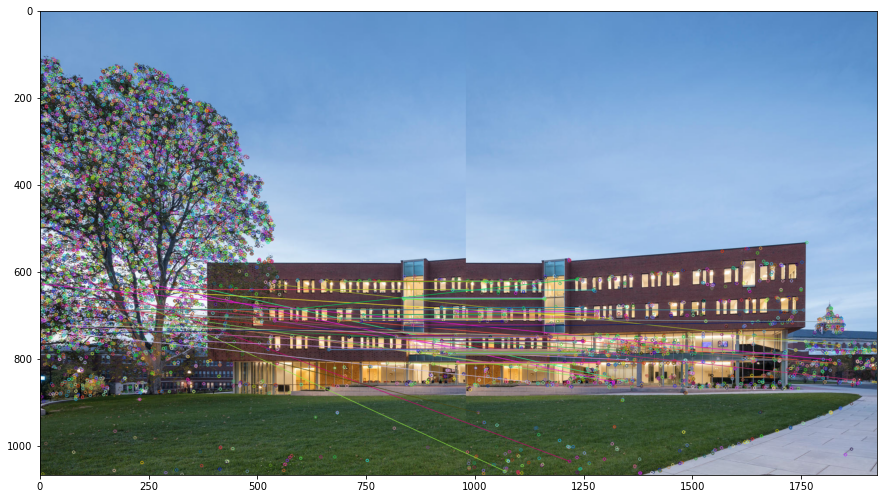

In [16]:
img3 = cv2.drawMatches(img1,k1,img2,k2,good_matches,None)
plt.figure(figsize = (15,20))
plt.imshow(img3)
plt.show()

## Fitting 

After finding the matches(correspondences) between two images, the goal of the fitting is to find the **transformation** between two images so that we can finally stitch them together.
Although we can find good matches between the two images, there are still many mismatches. 
Therefore, we'll implement RANSAC which is a general framework for model fitting in the presence of outliers.


### 1. Solve Homography
Similar to finding projection matrix, fitting with perspective matrix means given a set of matched feature points $\{p',p\}$ we want to find a  Projective Transform matrix such that
$$
p' =  \mathcal{H} * p, 
$$
The detailed derivation is in the lecture slides.
The function we are going to implement `computeHomographyMatrix(fourcorrs)` takes a list of four pairs and the return will be a `3*3` matrix.
>Hint: you might need to use `np.linalg.svd()` to compute the SVG decomposition.
### 2. Find the inliners

After getting the transform matrix, the next step is to find the fraction of inliers within a preset geometric distance.  
Specifically, we iterate through all matched points, and if
$$
L_2(p' - \mathcal{H}*p)<threshold
$$
we'll consider this match as an inlier.

`getInliers` return all inliers which is a sublist of the input `corrList`.
### 3. RANSAC

Here is the RANSAC algorithm outline:  

1. Randomly select four matches. 
>Hint: you can use `random.sample()` to randomly select from a list.
1. Solve for $\mathcal{H}$ parameters using `computeHomographyMatrix()` with sampled matches.
2. Use `getInliers()` to find all inliners with last step $\mathcal{H}$. 

Repeat 1-3 until # of inliners is greater than (# of all matches) * threshold, then return $\mathcal{H}$

In [9]:
def computeHomographyMatrix(fourcorrs):
      # 
    A = np.zeros((8,9))
    for i in range(len(fourcorrs)):
        p_,p = fourcorrs[i]
        x_,y_ = p_
        x,y = p 
        A[i*2] = [x,y,1,0,0,0,-x_*x,-x_*y,-x_]
        A[i*2+1] = [0,0,0,x,y,1,-y_*x,-y_*y,-y_]
    U,sigma,VT = np.linalg.svd(A)
    H = np.reshape(VT[8], (3, 3))
    H = (1/H.item(8)) * H
    return H

In [10]:
def getInliers(corrList, h, threshold=5):
    # 
    ans = []
    for p_,p in corrList:
        x_,y_ = p_
        x,y = p
        array_p_ = np.array([x_,y_,1]).reshape((3,1))
        array_p = np.array([x,y,1]).reshape((3,1))
        distance = np.linalg.norm(array_p_ - h.dot(array_p),ord=2,axis=0)
        if distance < threshold:
            ans.append((p_,p))
    return ans

In [11]:
def ransac(corrList, thresh):
    # 
    while(1):
        randomList = random.sample(corrList,4)
        H = computeHomographyMatrix(randomList)
        inliers = getInliers(corrList,H)
        if len(inliers) > len(corrList) * thresh:
            return H


## Alignment
Now you have everything to stitch images together. 
In the `stitch` function, all you need to do is to apply the transformation to img2 with estimated $\mathcal{H}$ and combine two images together.
> Hint: use `cv2.warpPerspective` to combine two images together.

In [12]:
def stitch(img1,img2,H):
    # 
    (x, y) = (img1.shape[1], img1.shape[0])
    cord_trans =  np.dot(H, np.array([x, y, 1]).reshape(3,1))
    result = cv2.warpPerspective(img2, H, (int(cord_trans[0, 0]), img2.shape[0]))
    result[0:img1.shape[0], 0:img1.shape[1]] = img1 
    return result

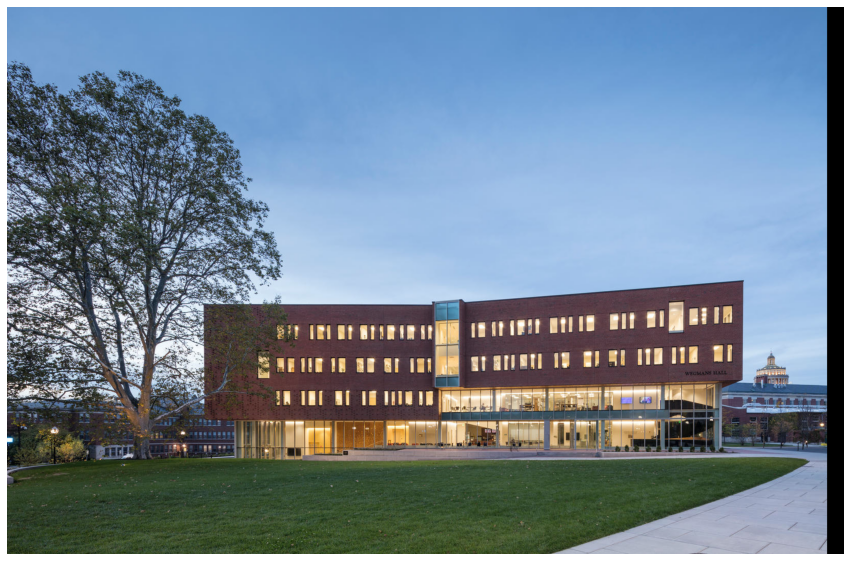

In [13]:
corrList = []
for match in good_matches:
    (x1, y1) = k1[match.queryIdx].pt
    (x2, y2) = k2[match.trainIdx].pt
    corrList.append([(x1, y1), (x2, y2)])
H= ransac(corrList, 0.6)
result = stitch(img1,img2,H)
plt.figure(figsize=(15,25))
plt.axis('off')
plt.imshow(result)
plt.show()

# Submission

1. At the menubar, click `Kernel`$\rightarrow$ `Restart & Run All`
2. Download the zip file and upload via blackboard
   
1% deduction of late assignment total score per hour passing the deadline.

In [14]:
# import csc249
# csc249.make_submission()

Archived: 2-motion.ipynb
Archived: 1-image-stitching.ipynb
Please summit this file at /Users/kerwin/courses/449MachineVision/449HW/problem-set-2/kerwin.zip
